In [42]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Para métricas de desempeño
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import MultilabelAccuracy
import numpy as np
import matplotlib.pyplot as plt

# Custom module to create synthetic dataset
from utils.sine_dataset import signal_dataset_multilabel

In [43]:
# LSTM parameters
hidden_dim = 20
n_signals = 1
N = 64
harmonics = 3
tagset_size = harmonics 


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [60]:
# Model creation
class LSTMHarmonic(nn.Module):
    """Some Information about LSTMHarmonic"""

    def __init__(self, N, hidden_dim, tagset_size):
        super(LSTMHarmonic, self).__init__()
        self.lstm = nn.LSTM(N, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])

        return torch.sigmoid(fc_layer)


model = LSTMHarmonic(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
print(f"Model structure: {model}\n")


Model structure: LSTMHarmonic(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)



In [61]:
# Define Dataset Class
# Define Dataset Class
class SineWaveDataset(torch.utils.data.Dataset):
    """Some Information about SineWaveDataset"""

    def __init__(self, signals, labels, transform=None, labels_transform=None):
        super(SineWaveDataset, self).__init__()
        self.signals = signals
        self.labels = labels
        self.transform = transform
        self.labels_transform = labels_transform

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]
        if self.transform:
            signal = self.transform(signal)
        if self.labels_transform:
            label = self.labels_transform(label)
        return signal, label

    def __len__(self):
        return len(self.signals)

In [62]:
# Dataset Parameters
fs = 3840
N = 64
m = 10000

# Create Dataset Signals
signals, target = signal_dataset_multilabel(fs, N, m)
signals = np.expand_dims(signals, axis=2)
signals = torch.from_numpy(signals).float()
target = torch.from_numpy(target).float()


# Create Dataset instance

dataset = SineWaveDataset(signals, target)
train_dataset, test_dataset, val_dataset = random_split(dataset, [0.9, 0.09, 0.01])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)


In [63]:
dataiter = iter(test_dataloader)
signal, labels = next(dataiter)
# labels = labels.to(torch.int64)[:5]
labels = labels[:5]
y = model(signal)[:5]
# y = torch.round(y).to(torch.int64)
y = torch.round(y)
print(labels)
print(y)
# from torchmetrics import ConfusionMatrix
# from torchmetrics.classification import MultilabelAccuracy
# confmat = ConfusionMatrix(task="multilabel", num_labels=4)
# confmat(y, labels)
# accuracy = MultilabelAccuracy(num_labels=4, average=None)
# print(accuracy(y, labels))

tensor([[1., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])
tensor([[1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]], grad_fn=<RoundBackward0>)


In [64]:
# Create Training / Test / Validation Loops

# Training
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 40 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    accuracy = MultilabelAccuracy(num_labels=3, average=None)

    test_loss, correct, actual_positives, predicted_positives = 0, 0, 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)

            test_loss += loss_fn(pred, y).item()
            actual_positives += y.sum()
            predicted_positives += torch.round(pred).sum()
            # correct += (torch.round(pred) == y).type(torch.float).sum().item()
            correct += accuracy(y.to(torch.int64), torch.round(pred).to(torch.int64))

    test_loss /= num_batches
    correct /= num_batches
    for index, n_label in enumerate(correct):
        print(
            f"Test Error {index} class: \n Accuracy: {(100*n_label.item()):>0.1f}%, Avg loss: {test_loss:>8f} \n"
        )


In [65]:
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n--------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

Epoch 1
--------------------------------
loss: 0.702126 [    0/ 9000]
loss: 0.514771 [ 2560/ 9000]
loss: 0.558067 [ 5120/ 9000]
loss: 0.504800 [ 7680/ 9000]
Test Error 0 class: 
 Accuracy: 75.8%, Avg loss: 0.464185 

Test Error 1 class: 
 Accuracy: 82.8%, Avg loss: 0.464185 

Test Error 2 class: 
 Accuracy: 82.3%, Avg loss: 0.464185 

Epoch 2
--------------------------------
loss: 0.510271 [    0/ 9000]
loss: 0.365130 [ 2560/ 9000]
loss: 0.245382 [ 5120/ 9000]
loss: 0.294691 [ 7680/ 9000]
Test Error 0 class: 
 Accuracy: 85.3%, Avg loss: 0.316882 

Test Error 1 class: 
 Accuracy: 78.9%, Avg loss: 0.316882 

Test Error 2 class: 
 Accuracy: 93.5%, Avg loss: 0.316882 

Epoch 3
--------------------------------
loss: 0.324157 [    0/ 9000]
loss: 0.320153 [ 2560/ 9000]
loss: 0.200058 [ 5120/ 9000]
loss: 0.229599 [ 7680/ 9000]
Test Error 0 class: 
 Accuracy: 92.4%, Avg loss: 0.197220 

Test Error 1 class: 
 Accuracy: 88.5%, Avg loss: 0.197220 

Test Error 2 class: 
 Accuracy: 97.1%, Avg loss: 

tensor([[1., 0., 0.],
        [0., 0., 0.],
        [1., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 1.],
        [0., 1., 1.]])
torch.Size([16, 64, 1])
tensor([[1., 0., 0.],
        [0., 0., 0.],
        [1., 1., 0.],
        [0., 1., 1.],
        [0., 0., 1.],
        [0., 1., 1.],
        [1., 0., 0.],
        [0., 1., 1.],
        [1., 1., 1.]], grad_fn=<RoundBackward0>)


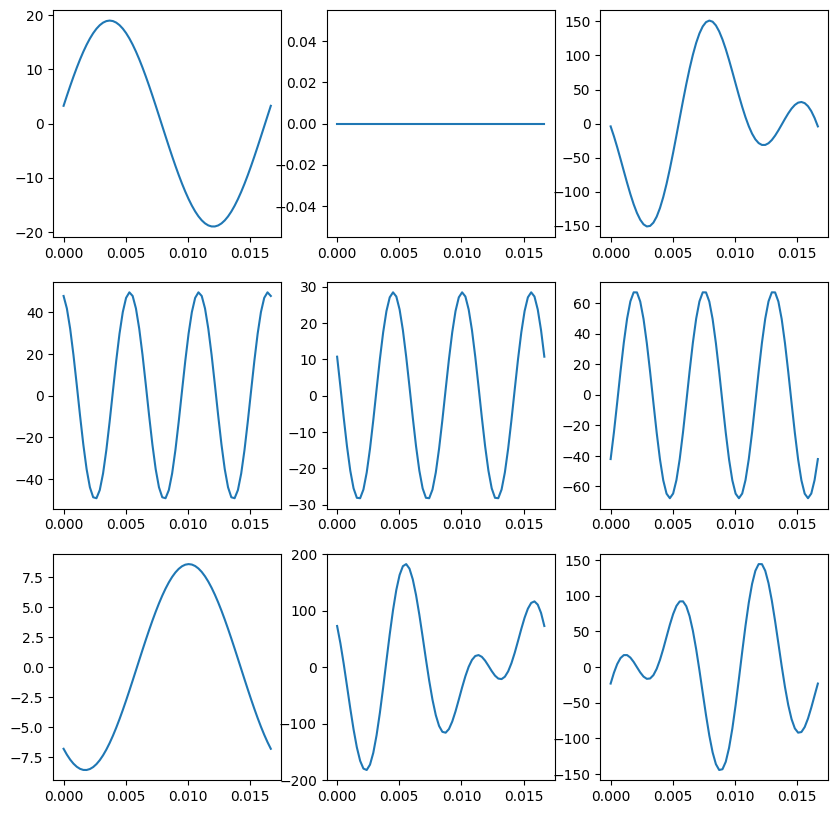

In [66]:
dataiter = iter(val_dataloader)
signal, labels = next(dataiter)
t = np.linspace(0, N / fs, N)
print(labels[1:10])
print(signal.shape)
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t, signal[i, :, 0])
x = model(signal[1:10].to(device))
print(torch.round(x))


(2000, 3)
[1. 1. 0.]


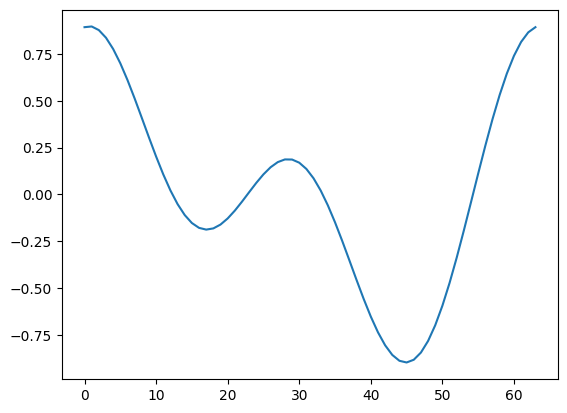

In [41]:
from utils.sine_dataset import signal_dataset_multilabel
import matplotlib.pyplot as plt
fs = 3840
N = 64
m = 2000
signals, labels = signal_dataset_multilabel(fs, N, m)
plt.plot(signals[10])
print(labels.shape)
print(labels[10])